# Распознавание животных на изображениях

Базовый ноутбук для домашнего задания по распознаванию животных.

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (Файл -> Создать копию на Диске). Свою копию вы сможете изменять и запускать.

Учебный курс "[Программирование глубоких нейронных сетей на Python](https://openedu.ru/course/urfu/PYDNN/)".

<a target="_blank" href="https://colab.research.google.com/github/sozykin/dlpython_course/blob/master/cnn/tensorflow/animals.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [138]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Rescaling, BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from tensorflow import data
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
import collections
%matplotlib inline

In [139]:
# Порядок классов животных
class_names=['cat',
             'elephant',
             'butterfly',
             'sheep',
             'spider',
             'horse',
             'dog',
             'cow',
             'chicken',
             'squirrel']

## Подготовка данных

Загружаем данные для обучения

In [140]:
# !curl -s -L -o train.zip "https://www.dropbox.com/scl/fi/t91ykrvtwupimxlf5xv9f/train.zip?rlkey=k0of0w0x6gsm0l33eylflub9c&dl=1"

Распаковываем архив с обучающим набором данных

In [141]:
# data_path = 'data'

In [142]:
# path = Path(data_path)

# if not path.exists():
#     path.mkdir(parents=True, exist_ok=True)

In [143]:
# with zipfile.ZipFile('train.zip', 'r') as zip_ref:
#     zip_ref.extractall(data_path)

**Создаем DataSet'ы**

In [144]:
batch_size = 64
image_size = (100, 100)

Набор данных для обучения

In [145]:
train_dataset = image_dataset_from_directory(
    "data/train",
    image_size=image_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    class_names=class_names,
    seed=42
)

Found 21949 files belonging to 10 classes.
Using 17560 files for training.


Проверочный набор данных

In [146]:
val_dataset = image_dataset_from_directory(
    "data/train",
    image_size=image_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    class_names=class_names,
    seed=42
)

class_counts = collections.Counter()

for images, labels in val_dataset:
    for label in labels.numpy():
        class_counts[label] += 1

total = sum(class_counts.values())
num_classes = len(class_counts)
class_weight = {}

for cls, count in class_counts.items():
    class_weight[int(cls)] = total / (num_classes * count)

Found 21949 files belonging to 10 classes.
Using 4389 files for validation.


**Просмотр примеров данных**

In [147]:
train_dataset.class_names

['cat',
 'elephant',
 'butterfly',
 'sheep',
 'spider',
 'horse',
 'dog',
 'cow',
 'chicken',
 'squirrel']

Аугментация данных

In [148]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),       # случайный поворот до 20%
    tf.keras.layers.RandomZoom(0.3),           # случайный зум до 30%
    tf.keras.layers.RandomFlip('horizontal'),  # случайное отражение по горизонтали
    tf.keras.layers.RandomContrast(0.2),       # случайный контраст до 20%
    tf.keras.layers.RandomBrightness(0.2),     # случайная яркость до 20%
])

# train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

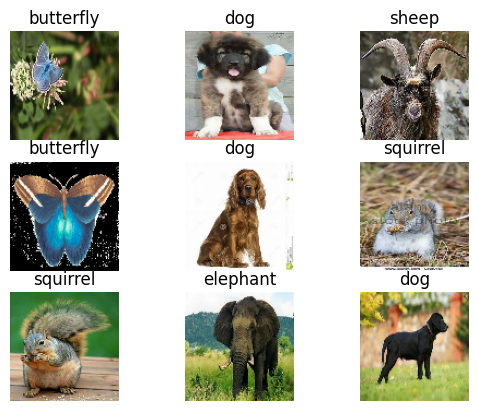

In [149]:
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

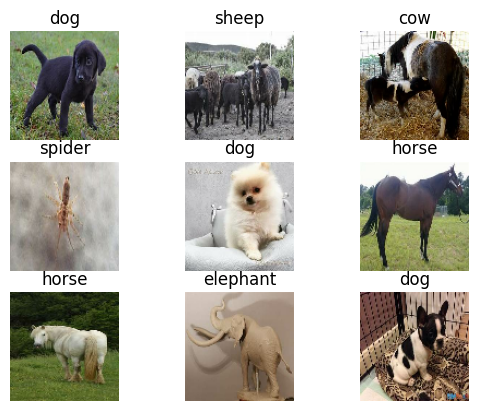

In [150]:
for images, labels in val_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**Настраиваем производительность работы DataSet'ов**

In [151]:
AUTOTUNE = data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## Создаем нейронную сеть

In [152]:
# Создаем последовательную модель
model = Sequential(
    [
        # Предварительная обработка: нормализация
        tf.keras.layers.Rescaling(1./255, input_shape=(*image_size, 3)),
        # Первый сверточный слой
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        # Первый слой подвыборки
        MaxPooling2D(pool_size=(2, 2)),
        # Слой регуляризации Dropout
        Dropout(0.2),

        # Второй сверточный слой
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        # Второй слой подвыборки
        MaxPooling2D(pool_size=(2, 2)),
        # Слой регуляризации Dropout
        Dropout(0.3),

        # Третий сверточный слой
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        # Третий слой подвыборки
        MaxPooling2D(pool_size=(2, 2)),
        # Слой регуляризации Dropout
        Dropout(0.3),

        # Четвёртый сверточный слой
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        # Четвёртый слой подвыборки
        MaxPooling2D(pool_size=(2, 2)),
        # Слой регуляризации Dropout
        Dropout(0.4),

        # Слой преобразования данных из 2D представления в плоское
        Flatten(),
        # Полносвязный слой для классификации
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        # Слой регуляризации Dropout
        Dropout(0.3),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        # Слой регуляризации Dropout
        Dropout(0.4),
        # Выходной полносвязный слой
        Dense(10, activation='softmax')
    ]
)

**Компилируем модель**

In [153]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Обучаем нейронную сеть

In [159]:
history = model.fit(train_dataset,
                    epochs=40,
                    validation_data=val_dataset,
                    class_weight=class_weight,
                    verbose=1)

Epoch 1/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.7654 - loss: 1.2012 - val_accuracy: 0.7241 - val_loss: 1.4215
Epoch 2/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7709 - loss: 1.1753 - val_accuracy: 0.6879 - val_loss: 1.5470
Epoch 3/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7787 - loss: 1.1699 - val_accuracy: 0.6683 - val_loss: 1.6514
Epoch 4/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7869 - loss: 1.1728 - val_accuracy: 0.7236 - val_loss: 1.5469
Epoch 5/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.8010 - loss: 1.1336 - val_accuracy: 0.7004 - val_loss: 1.6029
Epoch 6/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7851 - loss: 1.1400 - val_accuracy: 0.6849 - val_loss: 1.5882
Epoch 7/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.8086 - loss: 1.0779 - val_accuracy: 0.7403 - val_loss: 1.4197
Epoch 8/40
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7997 - loss: 1.1103 - val_accu

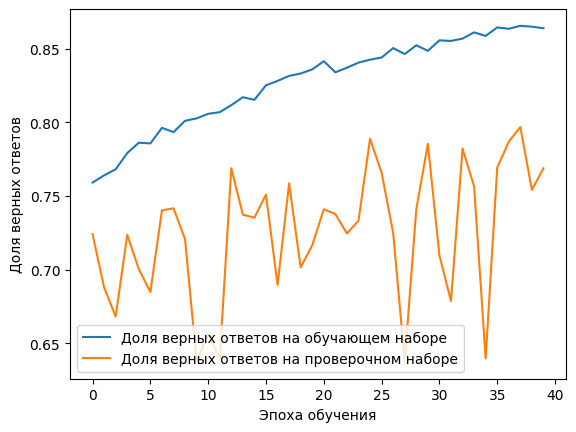

In [160]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

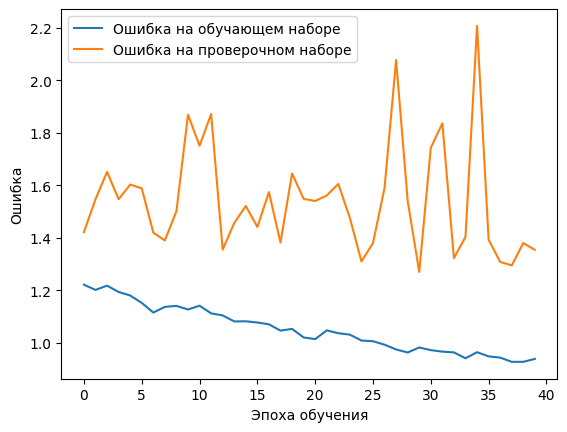

In [161]:
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

## Сохраняем обученную нейронную сеть

In [157]:
model.save("animals.keras")

## Применяем сеть для распознавания объектов на изображениях

**Смотрим загруженную картинку**

In [158]:
img_path = '../horse.jpg'
img = image.load_img(img_path, target_size=(100, 100))
plt.imshow(img)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../horse.jpg'

**Преобразуем картинку в массив для распознавания**

In [ ]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

**Запускаем распознавание**

In [ ]:
prediction = model.predict(x)

In [ ]:
prediction

In [ ]:
prediction = np.argmax(prediction)


In [ ]:
prediction

In [ ]:
print(class_names[prediction])

**Обязательно попробуйте распознать свои изображения!**

## Распознаем изображения их тестового набора данных

Загружаем данные для распознавания

In [ ]:
!curl -s -L -o test.zip "https://www.dropbox.com/scl/fi/ho3jmmnbpddu183p4nug0/test.zip?rlkey=595fmuikf204gq8gzfjvyr4b5&dl=1"

Распаковываем архив

In [ ]:
with zipfile.ZipFile('test.zip', 'r') as zip_ref:
    zip_ref.extractall(data_path)

Тестовый набор данных

In [ ]:
test_dataset = image_dataset_from_directory(
    "data/test",
    image_size=image_size,
    batch_size=batch_size,
    labels=None,
    shuffle=False,
)

In [ ]:
for images in test_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
predictions = model.predict(test_dataset)

In [ ]:
predictions[:10]

In [ ]:
predictions = np.argmax(predictions, axis=1)

In [ ]:
predictions[:10]

## Готовим файл с решением

In [ ]:
submission = pd.DataFrame({
    'filepath': test_dataset.file_paths,
    'label': predictions
})

In [ ]:
submission

In [ ]:
submission['id'] = submission['filepath'].apply(lambda x: Path(x).name)

In [ ]:
submission

In [ ]:
submission[['id','label']].to_csv('submission.csv',
                                  index=False)

## Идеи по улучшению качества решения

1. Попробуйте использовать разное количество блоков слой свертки + слой подвыборки.
2. Используйте разное количество сверточных слоев в блоке (1, 2, 3).
3. Используйте разные размеры свертки (3х3, 5х5, 7х7).
4. Используйте Data Augmentation.
5. Используйте разное количество нейронов в полносвязном слое.
6. Используйте несколько полносвязных слоев.
7. Используйте разное значение параметра dropout rate.
8. Используйте разное количество эпох: 10, 20, 30, 50, 100.
9. Используйте разные размеры мини-выборки (batch_size): 10, 50, 100, 200, 500.
10. Используйте разные [оптимизаторы](https://keras.io/api/optimizers/): adam, rmsprop и другие.


Подберить разные комбинации гиперпараметров таким образом, чтобы получить лучший результат на тестовом наборе данных.

Убедитесь, что в вашей модели нет переобучения.